## Feature Prototype (Baseline model stage)
In this stage, a convolutional neural network (CNN) based baseline model will be trained.

The following libraries are required for the data preparation process

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder

### Pre-processing images in training data
The training data will be read and stored as a pandas dataframe. By iterating through each image path, we are able to run ```preprocess_image()``` on each path. This function reads and resizes the image to a commonly used size for image classification, followed by normalising the pixel values. This is done with the help of the ```cv2``` library. To make the classification easier, all training labels of ```BENIGN_WITHOUT_CALLBACK``` would be categorised as ```BENIGN```.

In [2]:
train_data = pd.read_csv("datasets/csv/train_data.csv")

def preprocess_image(img_path):
    # reading images
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # target_size of 224, 224 commonly used for image classification
    img = cv2.resize(img, (224, 224))
    # normalising pixel values
    img_array = img.astype(np.float32) / 255
    return img_array

# using preprocessed images as train data
train_images = np.array([preprocess_image(image_path) for image_path in train_data["image_path"]])
# using "pathology" column as train labels
train_labels = np.array(train_data["pathology"])

# change "BENIGN_WITHOUT_CALLBACK" to "BENIGN"
for i in range(len(train_labels)):
    if train_labels[i] == "BENIGN_WITHOUT_CALLBACK":
        train_labels[i] = "BENIGN"

To ensure that the images have been processed, the first 25 images would be plotted together with their respective labels

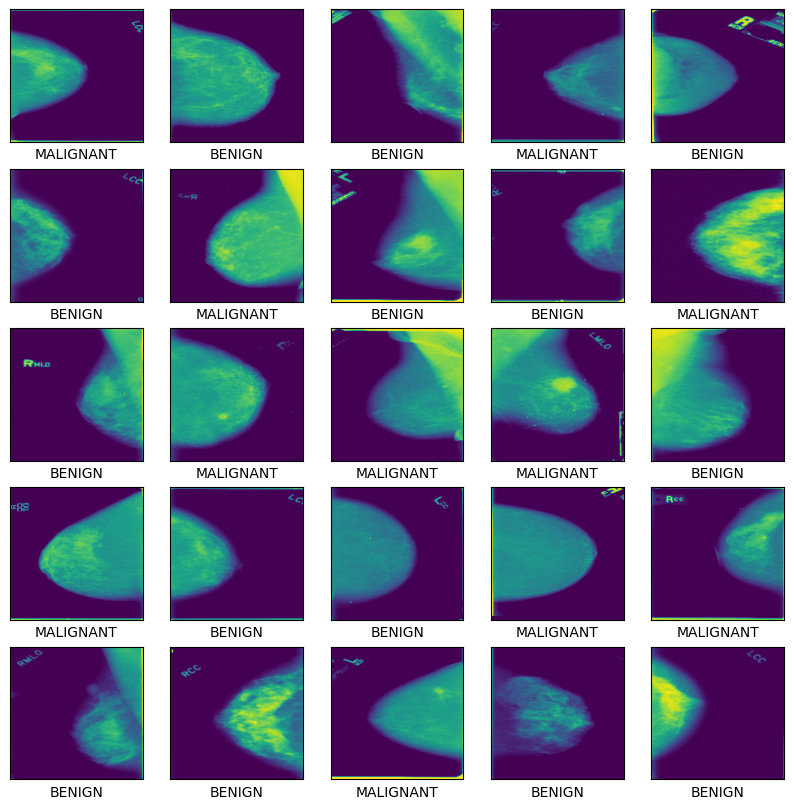

In [3]:
plt.figure(figsize = (10, 10))
# plot first 25
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(train_labels[i])
plt.show()

### Creating a base model
To understand how the model performs, ```Conv2D``` will be used for feature extraction and the input shape is set to the size of the image (224 as configured previously). ```MaxPooling2D``` is then used to conduct dimensionality reduction.

To unroll the output into a singular dimension (1D), flatten will be used.

In [4]:
base_model = Sequential()
# creating stack of Conv2D and MaxPooling2D
base_model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
base_model.add(MaxPooling2D((2, 2)))
#base_model.add(Conv2D(64, (3, 3), activation = "relu"))
#base_model.add(MaxPooling2D((2, 2)))
#base_model.add(Conv2D(128, (3, 3), activation = "relu"))
#base_model.add(MaxPooling2D((2, 2)))

# unrolling output to 1D
base_model.add(Flatten())
base_model.add(Dense(128, activation = "relu"))
# output layer with softmax
base_model.add(Dense(2, activation = "softmax"))

# base_model.summary()

### Pre-processing images in testing data
The testing data will be read and stored as a pandas dataframe. By iterating through each image path, we are able to run ```preprocess_image()``` on each path. This function reads and resizes the image to a commonly used size for image classification, followed by normalising the pixel values. This is done with the help of the ```cv2``` library. To make the classification easier, all training labels of ```BENIGN_WITHOUT_CALLBACK``` would be categorised as ```BENIGN```.

In addition, to keep the labels, a label encoder is required and one-hot encoding allows for the labels to be categorical.

In [5]:
test_data = pd.read_csv("datasets/csv/test_data.csv")

# using preprocessed images as test data
test_images = np.array([preprocess_image(image_path) for image_path in test_data["image_path"]])
# using "pathology" column as test labels
test_labels = np.array(test_data["pathology"])

# change "BENIGN_WITHOUT_CALLBACK" to "BENIGN"
for i in range(len(test_labels)):
    if test_labels[i] == "BENIGN_WITHOUT_CALLBACK":
        test_labels[i] = "BENIGN"
        
# encoding labels
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_test_labels = label_encoder.fit_transform(test_labels)
# one-hot encode labels
one_hot_train_labels = tf.keras.utils.to_categorical(encoded_train_labels)
one_hot_test_labels = tf.keras.utils.to_categorical(encoded_test_labels)

The model is then compiled and trained using the training set, and accuracy is tested using the test set.

In [6]:
# compile model, improving accuracy
base_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
# train model, validating on test set
history = base_model.fit(train_images, one_hot_train_labels, epochs = 10, validation_data = (test_images, one_hot_test_labels))

Epoch 1/10
74/74 [==============================] - 40s 527ms/step - loss: 1.0728 - accuracy: 0.5638 - val_loss: 0.6804 - val_accuracy: 0.5833
Epoch 2/10
74/74 [==============================] - 39s 523ms/step - loss: 0.6082 - accuracy: 0.6654 - val_loss: 0.6238 - val_accuracy: 0.6344
Epoch 3/10
74/74 [==============================] - 39s 522ms/step - loss: 0.5178 - accuracy: 0.7555 - val_loss: 0.6194 - val_accuracy: 0.6531
Epoch 4/10
74/74 [==============================] - 39s 523ms/step - loss: 0.4151 - accuracy: 0.8193 - val_loss: 0.6241 - val_accuracy: 0.6599
Epoch 5/10
74/74 [==============================] - 39s 523ms/step - loss: 0.2942 - accuracy: 0.8988 - val_loss: 0.7309 - val_accuracy: 0.6344
Epoch 6/10
74/74 [==============================] - 39s 527ms/step - loss: 0.1921 - accuracy: 0.9477 - val_loss: 0.7736 - val_accuracy: 0.6786
Epoch 7/10
74/74 [==============================] - 39s 526ms/step - loss: 0.1278 - accuracy: 0.9719 - val_loss: 0.8789 - val_accuracy: 0.6565

To understand the performance of this baseline model, the accuracy and validation accuracy would be plotted.

From the graph and the outputs printed above, whilst the accuracy has neared 100%, the validation accuracy is still seen to be low. This would suggest that whilst the training was successful, the categorisation is not generalised enough that the model did not perform well on unseen data.

19/19 - 2s - loss: 1.1807 - accuracy: 0.6327 - 2s/epoch - 95ms/step
test accuracy: 0.6326530575752258


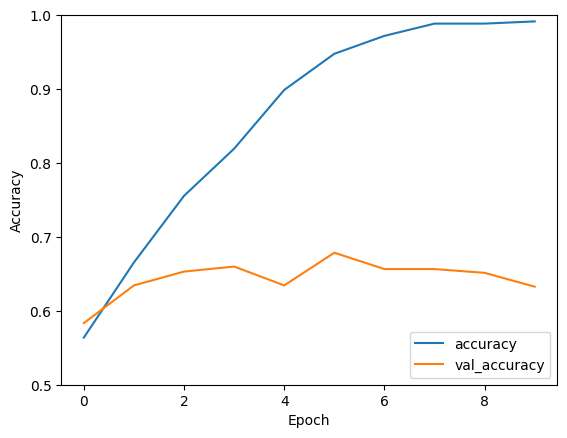

In [7]:
# evaluating the base_model
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1]) # accuracy between 0.5 to 1
plt.legend(loc = "lower right")
test_loss, test_acc = base_model.evaluate(test_images, one_hot_test_labels, verbose = 2)
print("test accuracy:", test_acc)

### Running baseline model with different optimisers
To find the best optimiser for this project, it is seen that ```tensorflow.keras``` has different types of optimisers.<br>By running each optimiser on the model, we would be able to select the best.

In [8]:
# creating models models
models = [Sequential() for i in range(6)]

for model in models:
    # creating stack of Conv2D and MaxPooling2D for each model
    model.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (224, 224, 1)))
    model.add(MaxPooling2D((2, 2)))
    # unrolling output to 1D for each model
    model.add(Flatten())
    model.add(Dense(128, activation = "relu"))
    # output layer with softmax for each model
    model.add(Dense(2, activation = "softmax"))

# compiling all types optimizers
optimizers = ["adam", "SGD", "RMSprop", "Adagrad", "Adadelta", "Nadam"]
for i in range(len(models)):
    models[i].compile(optimizer = optimizers[i], loss = "categorical_crossentropy", metrics = ["accuracy"])

The model is compiled and trained with different optimizers, and accuracy is tested using the test set.

In [9]:
# train models, validating on test set
histories = []
for i in range(len(models)):
    history = models[i].fit(train_images, one_hot_train_labels, epochs = 10, validation_data = (test_images, one_hot_test_labels))
    histories.append(history)

Epoch 1/10
74/74 [==============================] - 40s 532ms/step - loss: 1.3981 - accuracy: 0.5816 - val_loss: 0.6538 - val_accuracy: 0.6037
Epoch 2/10
74/74 [==============================] - 39s 523ms/step - loss: 0.6231 - accuracy: 0.6467 - val_loss: 0.6257 - val_accuracy: 0.6207
Epoch 3/10
74/74 [==============================] - 39s 521ms/step - loss: 0.5582 - accuracy: 0.7139 - val_loss: 0.6279 - val_accuracy: 0.6276
Epoch 4/10
74/74 [==============================] - 39s 531ms/step - loss: 0.4878 - accuracy: 0.7785 - val_loss: 0.6516 - val_accuracy: 0.6224
Epoch 5/10
74/74 [==============================] - 39s 525ms/step - loss: 0.3862 - accuracy: 0.8299 - val_loss: 0.7146 - val_accuracy: 0.6207
Epoch 6/10
74/74 [==============================] - 39s 525ms/step - loss: 0.2945 - accuracy: 0.8869 - val_loss: 0.6975 - val_accuracy: 0.6531
Epoch 7/10
74/74 [==============================] - 39s 522ms/step - loss: 0.2101 - accuracy: 0.9354 - val_loss: 0.7698 - val_accuracy: 0.6446

### Output to find best optimizer
Adam Epoch 10/10:<br>
74/74 [==============================] - 39s 523ms/step - loss: 0.0672 - accuracy: 0.9894 - val_loss: 0.9592 - val_accuracy: 0.6548
<br>SGD Epoch 10/10:<br>
74/74 [==============================] - 28s 373ms/step - loss: 0.6398 - accuracy: 0.6305 - val_loss: 0.6651 - val_accuracy: 0.5986
<br>RMS Prop Epoch 10/10:<br>
74/74 [==============================] - 36s 486ms/step - loss: 0.2304 - accuracy: 0.9184 - val_loss: 0.8472 - val_accuracy: 0.6361
<br>Adagrad Epoch 10/10:<br>
74/74 [==============================] - 34s 466ms/step - loss: 0.6432 - accuracy: 0.6437 - val_loss: 0.6454 - val_accuracy: 0.6378
<br>Adadelta Epoch 10/10:<br>
74/74 [==============================] - 46s 616ms/step - loss: 0.6609 - accuracy: 0.6122 - val_loss: 0.6694 - val_accuracy: 0.5782
<br>Nadam Epoch 10/10:<br>
74/74 [==============================] - 45s 614ms/step - loss: 0.3509 - accuracy: 0.8465 - val_loss: 0.6720 - val_accuracy: 0.6684

To understand the performance of this baseline model, the accuracy and validation accuracy of each model would be plotted.

In [12]:
# for history in histories:
#     # evaluating the base_model
#     plt.plot(history.history["accuracy"], label = "accuracy")
#     plt.plot(history.history["val_accuracy"], label = "val_accuracy")
#     plt.xlabel("Epoch")
#     plt.ylabel("Accuracy")
#     plt.ylim([0.5, 1]) # accuracy between 0.5 to 1
#     plt.legend(loc = "lower right")
#     test_loss, test_acc = base_model.evaluate(test_images, one_hot_test_labels, verbose = 2)
#     print("test accuracy:", test_acc)

In [10]:
# # Adam optimiser
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
# # SGD (Stochastic Gradient Descent) Optimizer
# sgd_optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9)
# # RMSprop Optimizer
# RMS_optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
# # Adagrad Optimizer
# adagrad_optimizer = tf.keras.optimizers.Adagrad(learning_rate = 0.01)
# # Adadelta Optimizer
# adadelta_optimizer = tf.keras.optimizers.Adadelta(learning_rate = 1.0)
# # Nadam Optimizer
# nadam_optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.002)